# Chess Board Position Recogniser

## Setup

### Libraries

In [17]:
import pathlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from PIL import Image

import chess

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

import wandb

In [2]:
tf.__version__

'2.10.0'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Constants

In [4]:
DATA_DIR = pathlib.Path.cwd().parent / "data" / "deepconvchess-dataset" / "dataset"

NUM_CLASSES = len(['_', 'p', 'n', 'b', 'r', 'q', 'k', 'P', 'N', 'B', 'R', 'Q', 'K'])

## Create TensorFlow Dataset

### Crop Each Image To 64 Partitions

In [5]:
# Dataset
X = []
y = []

for file in DATA_DIR.iterdir():
    if file.is_file() and file.name.endswith(".jpeg"):
        print("Processing %s" % file.name)

        fen = file.name.split(".")[0]
        fen = fen.replace("_", "/")
        board = chess.Board(fen)
        
        # Open image of Chess board
        img = Image.open(DATA_DIR / file.name)
        IMG_WIDTH, IMG_HEIGHT = img.size

        # Crop each image into 64 sections, one for each tile on the board
        for i in range(8):
            for j in range(8):
                crop_x = j * IMG_WIDTH // 8
                crop_y = i * IMG_HEIGHT // 8
                img_crop = img.crop((crop_x, crop_y, crop_x + IMG_WIDTH // 8, crop_y + IMG_HEIGHT // 8))

                piece = board.piece_at(((7 - i) * 8) + j)
                if piece is not None:
                    piece = piece.symbol()
                else:
                    piece = '_'

                X.append(np.array(img_crop))
                y.append(piece)

Processing 1N2r3_2q1ppkp_1p1p1np1_p1nP4_2P2P2_1P4P1_P2Q2BP_3RR1K1 b - - 0 21.jpeg
Processing 1q2r3_4ppkp_1p1p1np1_p1nP4_2P2P2_1P4P1_P2Q2BP_3RR1K1 w - - 0 22.jpeg
Processing 1q2r3_4ppkp_1p1p1np1_p1nP4_2PQ1P2_1P4P1_P5BP_3RR1K1 b - - 1 22.jpeg
Processing 1r1q1rk1_1ppb1pbp_p1np1np1_8_2PNP3_2N1BP2_PP1QB1PP_R4RK1 w - - 6 12.jpeg
Processing 1r1Q2k1_5ppp_2q1p3_1p6_2p2P2_P3P3_1Q4PP_1R4K1 b - - 0 27.jpeg
Processing 1r1qr3_1b1nppkp_pp1p2p1_2n5_2PNP3_1PN3P1_P2Q1PBP_3RR1K1 w - - 2 17.jpeg
Processing 1r1qr3_1b1nppkp_pp1p2p1_2n5_2PNPP2_1PN3P1_P2Q2BP_3RR1K1 b - - 0 17.jpeg
Processing 1r1qr3_1b2ppkp_pp1p1np1_2n5_2PNP3_1PN3P1_P2Q1PBP_3RR1K1 b - - 1 16.jpeg
Processing 1r1qr3_1b2ppkp_pp1p1np1_2n5_2PNP3_1PN3P1_P2Q1PBP_R3R1K1 w - - 0 16.jpeg
Processing 1r1qr3_pb2ppkp_1p1p1np1_2n5_2PNP3_1PN3P1_P2Q1PBP_R3R1K1 b - - 0 15.jpeg
Processing 1r1qr3_pb2ppkp_1p1p1np1_2n5_2PNP3_2N3P1_PP1Q1PBP_R3R1K1 w - - 3 15.jpeg
Processing 1r2r3_1bqnppkp_pp1p2p1_2n5_2PNPP2_1PN3P1_P2Q2BP_3RR1K1 w - - 1 18.jpeg
Processing 1r2r3_1bqnp

In [6]:
len(X)

30208

In [7]:
X = np.array(X)
y = np.array(y)

### Display Example Cropped Board

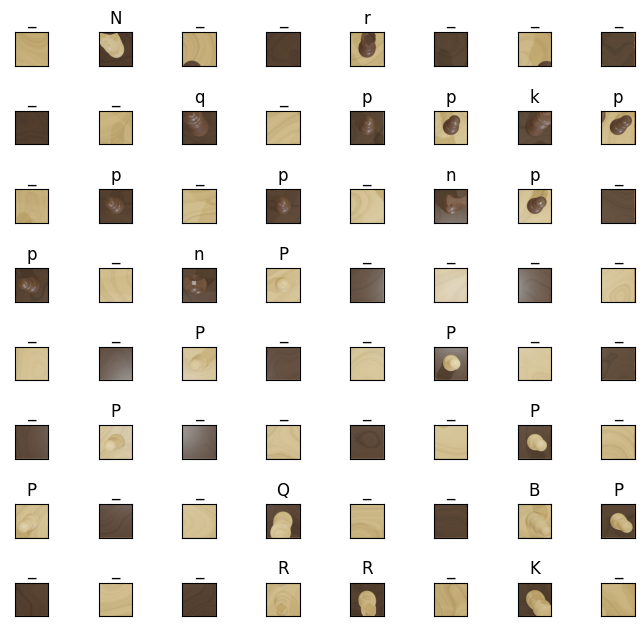

In [8]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=1.5)

for i in range(0, 64):
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(X[i])
    plt.title(y[i])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

### Encode Labels

In [9]:
# Define the labels
labels = ['_', 'p', 'n', 'b', 'r', 'q', 'k', 'P', 'N', 'B', 'R', 'Q', 'K']

label_encoder = LabelEncoder()
label_encoder.fit(labels)
y = label_encoder.transform(y)

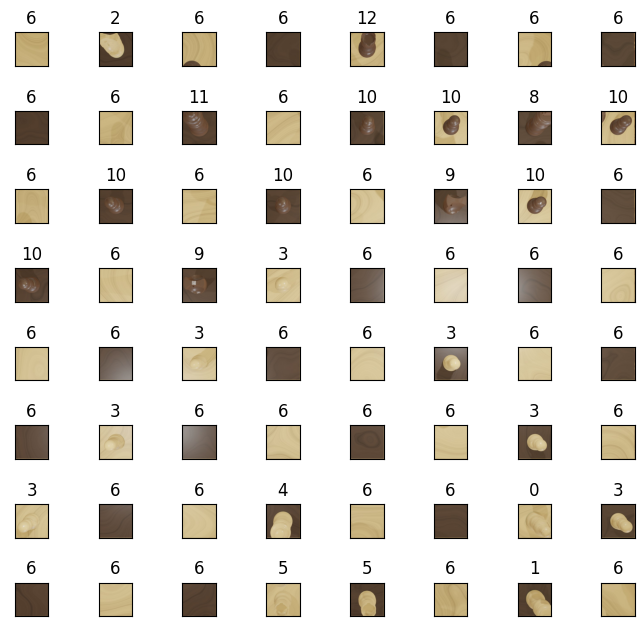

In [10]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=1.5)

for i in range(0, 64):
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(X[i])
    plt.title(y[i])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

### Test and Train Split

In [11]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Print the shapes of the train and test split
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (24166, 160, 160, 3)
y_train shape: (24166,)
X_test shape: (6042, 160, 160, 3)
y_test shape: (6042,)


## Weights and Bias

### Callback to Log Statistics

In [12]:
class EpochLogCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        train_loss = logs.get('loss')
        
        val_acc = logs.get('val_accuracy')
        val_loss = logs.get('val_loss')

        wandb.log(
            {
                'accuracy': train_acc, 
                'loss': train_loss,
                'val_accuracy': val_acc,
                'val_loss': val_loss
            }
        )

## Models

### ResNet

#### ResNet-50

In [13]:
# Start W&B Run
wandb.init(
    project="deepconvchess",
    config={
        "architecture": "renset50",
        "optimizer": "adam",
        "learning_rate": 0.0001,
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "batch_size": 32,
        "epochs": 5,
    }
)

config = wandb.config

# Create Model
resnet_model = ResNet50(input_shape=(160, 160, 3), include_top=False)
resnet_model.trainable = False

model = Sequential([
    resnet_model, 
    Flatten(), 
    Dense(NUM_CLASSES, activation='softmax', name='output') # Additional output layer for chess pieces
], name="resnet50")

# Create Optimizer
if config.optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile Model
model.compile(optimizer=optimizer, loss=config.loss, metrics=[config.metric])

# Build Model
history = model.fit(X_train, 
                    y_train,
                    batch_size=config.batch_size,
                    epochs=config.epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[EpochLogCallback()])

# Finish W&B Run
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: billy-wba8. Use `wandb login --relogin` to force relogin


Epoch 1/5
756/756 [==============================] - 32s 38ms/step - loss: 0.0522 - accuracy: 0.9888 - val_loss: 0.0152 - val_accuracy: 0.9969
Epoch 2/5
756/756 [==============================] - 27s 35ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0068 - val_accuracy: 0.9990
Epoch 3/5
756/756 [==============================] - 27s 36ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0089 - val_accuracy: 0.9990
Epoch 4/5
756/756 [==============================] - 26s 34ms/step - loss: 6.7082e-05 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 0.9990
Epoch 5/5
756/756 [==============================] - 26s 34ms/step - loss: 3.8347e-05 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 0.9990


accuracy,▁████
loss,█▁▁▁▁
val_accuracy,▁████
val_loss,█▁▃▁▁
accuracy,1.0
loss,4e-05
val_accuracy,0.99901
val_loss,0.00691


### MobileNet

#### MobileNetV1

In [18]:
# Start W&B Run
wandb.init(
    project="deepconvchess",
    config={
        "architecture": "mobilenetv1",
        "optimizer": "adam",
        "learning_rate": 0.0001,
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "batch_size": 32,
        "epochs": 5,
    }
)

config = wandb.config

# Create Model
mobilenet_model = MobileNet(input_shape=(160, 160, 3), include_top=False)
mobilenet_model.trainable = False

model = Sequential([
    mobilenet_model, 
    Flatten(), 
    Dense(NUM_CLASSES, activation='softmax', name='output') # Additional output layer for chess pieces
], name="resnet50")

# Create Optimizer
if config.optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile Model
model.compile(optimizer=optimizer, loss=config.loss, metrics=[config.metric])

# Build Model
history = model.fit(X_train, 
                    y_train,
                    batch_size=config.batch_size,
                    epochs=config.epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[EpochLogCallback()])

# Finish W&B Run
wandb.finish()

17225924/17225924 [==============================] - 2s 0us/step
Epoch 1/5
756/756 [==============================] - 12s 14ms/step - loss: 0.2396 - accuracy: 0.9371 - val_loss: 0.1014 - val_accuracy: 0.9753
Epoch 2/5
756/756 [==============================] - 10s 14ms/step - loss: 0.0546 - accuracy: 0.9885 - val_loss: 0.0605 - val_accuracy: 0.9866
Epoch 3/5
756/756 [==============================] - 11s 14ms/step - loss: 0.0285 - accuracy: 0.9947 - val_loss: 0.0467 - val_accuracy: 0.9894
Epoch 4/5
756/756 [==============================] - 11s 14ms/step - loss: 0.0160 - accuracy: 0.9977 - val_loss: 0.0339 - val_accuracy: 0.9909
Epoch 5/5
756/756 [==============================] - 11s 14ms/step - loss: 0.0098 - accuracy: 0.9990 - val_loss: 0.0280 - val_accuracy: 0.9927


accuracy,▁▇███
loss,█▂▂▁▁
val_accuracy,▁▆▇▇█
val_loss,█▄▃▂▁
accuracy,0.99897
loss,0.00978
val_accuracy,0.99272
val_loss,0.02796


### Evaluate Model

Text(0.5, 1.0, '8')

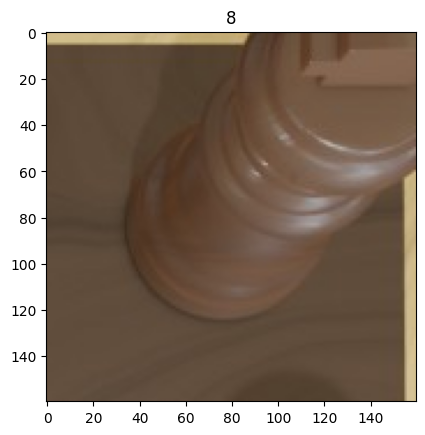

In [14]:
plt.imshow(X_test[0])
plt.title(y_test[0])

#### Predictions

In [15]:
for i in range(0, 8):
    image = np.expand_dims(X_test[i], axis=0)

    prediction = model.predict(image)
    prediction = label_encoder.inverse_transform(np.argmax(prediction, axis=1))

    print("True Label: %s, Predicted Label: %s\n" % (label_encoder.inverse_transform([y_test[i]]), prediction))

1/1 [==============================] - 1s 648ms/step
True Label: ['k'], Predicted Label: ['k']

1/1 [==============================] - 0s 19ms/step
True Label: ['_'], Predicted Label: ['_']

1/1 [==============================] - 0s 19ms/step
True Label: ['p'], Predicted Label: ['p']

1/1 [==============================] - 0s 20ms/step
True Label: ['_'], Predicted Label: ['_']

1/1 [==============================] - 0s 20ms/step
True Label: ['_'], Predicted Label: ['_']

1/1 [==============================] - 0s 20ms/step
True Label: ['_'], Predicted Label: ['_']

1/1 [==============================] - 0s 19ms/step
True Label: ['Q'], Predicted Label: ['Q']

1/1 [==============================] - 0s 19ms/step
True Label: ['P'], Predicted Label: ['P']

